# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [53]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [54]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [55]:
# isolate the independent and dependent variables
X_pocket = ANES[['pocketEval']]
X_econ = ANES[['econEval']]
X_ols = ANES[['pocketEval', 'econEval']]
y = ANES['trumpft']

# run the OLS regression for the pocket and econ evaluations
X_ols = sm.add_constant(X_ols)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# export the results to a .tex file
with open('outputs/ols_results.tex', 'w') as tf:
    tf.write(model_ols.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1939.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:17:48   Log-Likelihood:                -39332.
No. Observations:                7998   AIC:                         7.867e+04
Df Residuals:                    7995   BIC:                         7.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5503      0.426    123.293      0.0

## More Complex OLS Regressions (+ Covariates)

In [56]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# run the OLS regression for the simultaneous pocket and econ evaluations with covariates
regression_cols = ['pocketEval', 'econEval'] + covariates
X_ols_covs = ANES[regression_cols]
X_ols_covs = sm.add_constant(X_ols_covs)
model_ols_covs = sm.OLS(y, X_ols_covs).fit()
print(model_ols_covs.summary())

# export the results to a .tex file
with open('outputs/ols_covs_results.tex', 'w') as tf:
    tf.write(model_ols_covs.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:17:48   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.5316 

## Train/Test Split

In [57]:
# define X pocket_cov and X econ_cov
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_econ_cov = ANES[['econEval'] + covariates]

# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# standardize the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

print(X_pocket_cov_train.head())
print("now econ")
print(X_econ_cov_train.head())
#scaler_y = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


   pocketEval  mode  prepost   sp_serv  sp_serv_biden  sp_serv_trump  \
0         1.0   1.0      1.0  0.066667       1.000000       0.000000   
1        -1.0   1.0     -1.0  0.600000       1.000000      -1.000000   
2         0.0   1.0      1.0 -0.333333       1.000000      -0.666667   
3         0.5   1.0      1.0  1.000000      -0.333333      -1.000000   
4         1.0   1.0      1.0  0.333333       0.000000      -0.666667   

   jobs_living  jobs_living_biden  jobs_living_trump  envir_business  ...  \
0     0.000000           0.000000           0.000000       -0.066667  ...   
1     0.666667          -0.333333          -1.000000       -1.000000  ...   
2     0.000000          -1.000000           0.666667        0.333333  ...   
3     0.000000           0.000000           1.000000       -0.333333  ...   
4    -0.666667           0.000000           0.666667       -1.000000  ...   

   immigration  gun_diff  offensive_language  harassment  no_children  \
0    -1.000000       1.0       

## LASSO Regression

In [58]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.05, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.05, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# print the intercept, number of nonzero coefficients, and the names of nonzero coefficients
print('Lasso Pocket Model:')
print('Intercept:', lasso_pocket.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_pocket.coef_))
print('Nonzero Coefficients:', X_pocket_cov.columns[lasso_pocket.coef_ != 0].tolist())

print('\nLasso Econ Model:')
print('Intercept:', lasso_econ.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_econ.coef_))
print('Nonzero Coefficients:', X_econ_cov.columns[lasso_econ.coef_ != 0].tolist())

Lasso Pocket Model:
Intercept: [-0.02034677]
Number of Nonzero Coefficients: 8
Nonzero Coefficients: ['envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']

Lasso Econ Model:
Intercept: [-0.02031254]
Number of Nonzero Coefficients: 9
Nonzero Coefficients: ['econEval', 'envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']


## Neural Network (?)

In [59]:
# train a neural network on pocketEval model
class ANESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=50):
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=64, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader

anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3643760034441948, Test Loss: 0.09385821253061294
Epoch 2, Train Loss: 0.1859329828619957, Test Loss: 0.09816124945878983
Epoch 3, Train Loss: 0.15009424589574338, Test Loss: 0.08815579250454902
Epoch 4, Train Loss: 0.1352031873911619, Test Loss: 0.0918990358710289
Epoch 5, Train Loss: 0.12562653318047523, Test Loss: 0.08926020100712777
Epoch 6, Train Loss: 0.12060995124280453, Test Loss: 0.0864176008105278
Epoch 7, Train Loss: 0.12015538964420557, Test Loss: 0.08195507943630219
Epoch 8, Train Loss: 0.11509509671479463, Test Loss: 0.08177002161741256
Epoch 9, Train Loss: 0.1175853219628334, Test Loss: 0.08145778983831406
Epoch 10, Train Loss: 0.11738525070250035, Test Loss: 0.08257904127240182
Epoch 11, Train Loss: 0.11072462566196918, Test Loss: 0.07975989148020744
Epoch 12, Train Loss: 0.1163850973546505, Test Loss: 0.08226373463869095
Epoch 13, Train Loss: 0.10810064762830734, Test Loss: 0.08240229412913322
Epoch 14, Train Loss: 0.10825908817350864, Test Loss: 

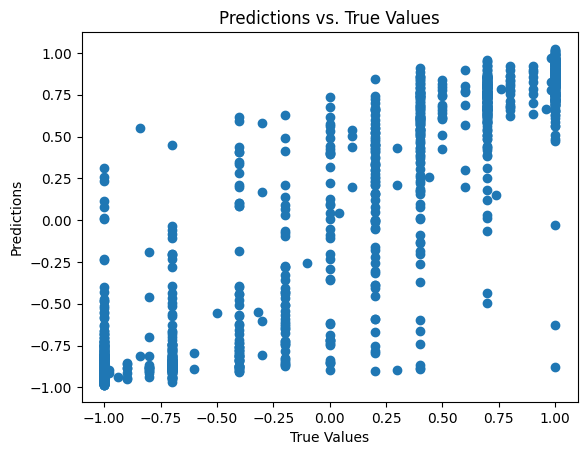

In [60]:
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()


In [61]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3275882488489151, Test Loss: 0.09515103369951249
Epoch 2, Train Loss: 0.1727586208283901, Test Loss: 0.08545072644948959
Epoch 3, Train Loss: 0.14191701523959638, Test Loss: 0.08734510034322739
Epoch 4, Train Loss: 0.1304393871128559, Test Loss: 0.08587383419275284
Epoch 5, Train Loss: 0.12224327400326729, Test Loss: 0.08404708802700042
Epoch 6, Train Loss: 0.11904609695076943, Test Loss: 0.08433584004640579
Epoch 7, Train Loss: 0.1178228123486042, Test Loss: 0.08523692518472671
Epoch 8, Train Loss: 0.11934793826192618, Test Loss: 0.08503922238945961
Epoch 9, Train Loss: 0.11613952290266752, Test Loss: 0.08407820403575897
Epoch 10, Train Loss: 0.1147543067112565, Test Loss: 0.08422101154923439
Epoch 11, Train Loss: 0.11168044030666352, Test Loss: 0.08221065774559974
Epoch 12, Train Loss: 0.11165606986731291, Test Loss: 0.08256967321038246
Epoch 13, Train Loss: 0.1088357637450099, Test Loss: 0.08237781643867492
Epoch 14, Train Loss: 0.11083475016057491, Test Loss:

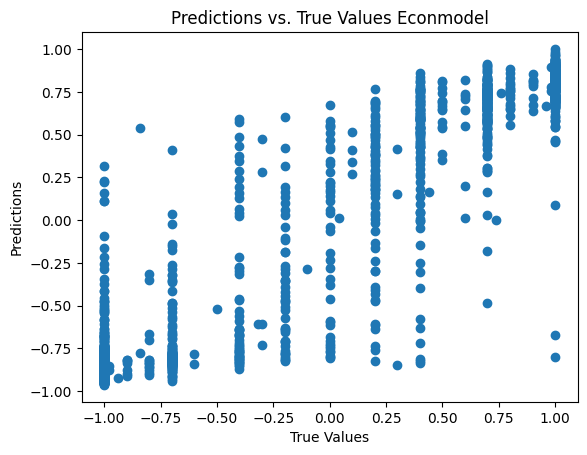

R^2 value for pocketEval model: 0.8800323374374818
R^2 value for econEval model: 0.8792427339243097


In [62]:
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values Econmodel')
plt.show()

from sklearn.metrics import r2_score
print('R^2 value for pocketEval model:', r2_score(y_test_pocket, pocket_predictions))
print('R^2 value for econEval model:', r2_score(y_test_econ, econ_predictions))

## Random Forest

In [ ]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_pocket = y_train_pocket.values.ravel()
rf_pocket.fit(X_pocket_cov_train, y_train_pocket)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

# get random forest prediction accuracy on pocket test
rf_pocket.score(X_pocket_cov_test, y_test_pocket)
print('Random Forest accuracy on pocketEval model:', rf_pocket.score(X_pocket_cov_test, y_test_pocket))

Random Forest accuracy on pocketEval model: 0.8851968120802028


In [ ]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_econ = y_train_econ.values.ravel()
rf_econ.fit(X_econ_cov_train, y_train_econ)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

# get random forest prediction accuracy on econ test
rf_econ.score(X_econ_cov_test, y_test_econ)
print('Random Forest accuracy on econEval model:', rf_econ.score(X_econ_cov_test, y_test_econ))